<b> <font size="+2.5"> Differential expression analysis in <u> major cell types </u> using dreamlet
 </b> </font> <br>

Date: 2023-11-23 <br>
Author: ASF

In [1]:
# see github code from:
# https://github.com/GabrielHoffman/dreamlet_analysis
# https://bioconductor.org/packages/devel/bioc/vignettes/dreamlet/inst/doc/dreamlet.html 

# Load libraries

In [1]:
suppressPackageStartupMessages({
library(SingleCellExperiment)
library(zellkonverter)
library(dreamlet)
library(zenith)
library(DelayedArray)
library(GSEABase)
library(cowplot)
library(tidyverse)
library(kableExtra)
library(qvalue)
library(scattermore)
library(RColorBrewer)
library(corrplot)
library(viridis)
library(dplyr)
library(org.Hs.eg.db)
library(EnrichmentBrowser)
library(ggrepel)
library(rhdf5)
library(HDF5Array)
library(gridExtra)
library(grid)
library(readxl)
library(writexl)
})

# Read in anndata object and make pseudobulk

## read in h5ad file

In [2]:
file <- "../datasets/adata_celltypes_after_manual_curation_20231120.h5ad"
sce <- readH5AD(file, use_hdf5=TRUE, verbose=FALSE)

Warning message:
“The names of these selected uns items have been modified to match R
conventions: '6-Batch_colors' -> 'X6.Batch_colors'”
Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”


In [3]:
#formating

# Set missing RIN to median
sce$RIN[is.na(sce$RIN)] = median(sce$RIN, na.rm=TRUE) 

sce$Status <- as.factor(as.character(sce$Status))
sce$Status <- factor(sce$Status, c('0','1'))

sce$X6.Batch <- as.character(sce$X6.Batch)

sce$Disease_Status <- ifelse(sce$Status=='0', 'Controls', 'Cases')
sce$Disease_Status <- factor(sce$Disease_Status, levels=c('Controls', 'Cases'))

In [4]:
sce

class: SingleCellExperiment 
dim: 26195 787685 
metadata(27): X6.Batch_colors Main.Batch_colors ... sample_colors umap
assays(3): X counts sct_corrected
rownames(26195): AL627309.1 AL627309.5 ... AC007325.4 AC007325.2
rowData names(14): gene_ids mito ... dispersions_norm varm
colnames(787685): AAACCCACAATCTCTT-1-0-0 AAACCCAGTAGCTAAA-1-0-0 ...
  TTTGTTGTCAGCTTCC-1-91-90 TTTGTTGTCGACCCAG-1-91-90
colData names(71): sample individual ... major_celltypes Disease_Status
reducedDimNames(2): X_pca X_umap
mainExpName: NULL
altExpNames(0):

## compute pseudobulk

In [5]:
# counts here should represent the raw counts
pb <- aggregateToPseudoBulk(sce,
    assay = "counts",     
    cluster_id = "major_celltypes",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

In [6]:
# read in PC1_hidden_noise
PC1 <- read_xlsx(path = "../datasets/PC1_hidden_confounders.xlsx")
#this table needs to be in the same order (individual) as colData
# check: 
unique(colData(pb)$individual == PC1$individual)

pb$PC1 <- PC1$PC1_hidden_noise
#pb@colData
#pb

[1] TRUE

# Summarize the data

In [8]:
# cell type order
ctorder <- c('Exc_Neurons', 'In_Neurons', 'Astrocytes',
            'Microglia','Oligodendrocyte', 'OPC', 'Endothelial')

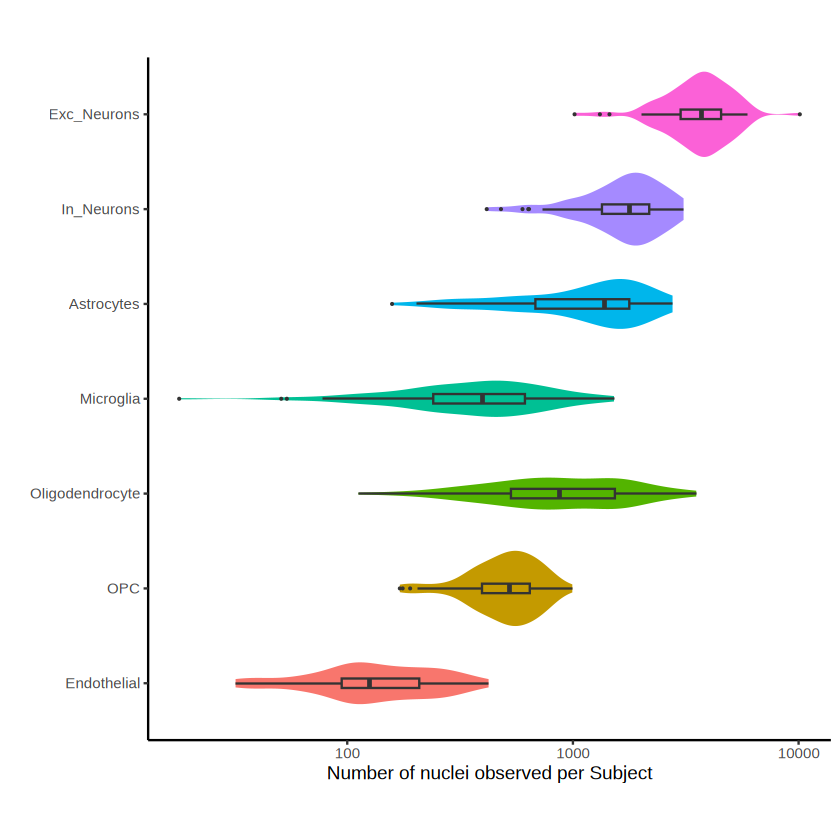

In [10]:
# Number of cells observed per Subject
options(warn=-1)
fig.cells_subject = colData(sce) %>%
  xtabs( ~ sample + major_celltypes,.) %>%
  as_tibble %>%
  pivot_longer(cols=sample) %>%
  mutate(subclass = factor(major_celltypes, rev(ctorder))) %>%  
  ggplot(aes(subclass, n, fill=subclass)) + 
    geom_violin(color = NA) + 
    geom_boxplot(width=.1, outlier.size=.1) +
    theme_classic() + 
    theme(aspect.ratio=1, plot.title = element_text(hjust = 0.5),
      legend.position="none") + 
    scale_y_log10() +
    coord_flip() +
    ylab("Number of nuclei observed per Subject") +
    xlab('')
fig.cells_subject

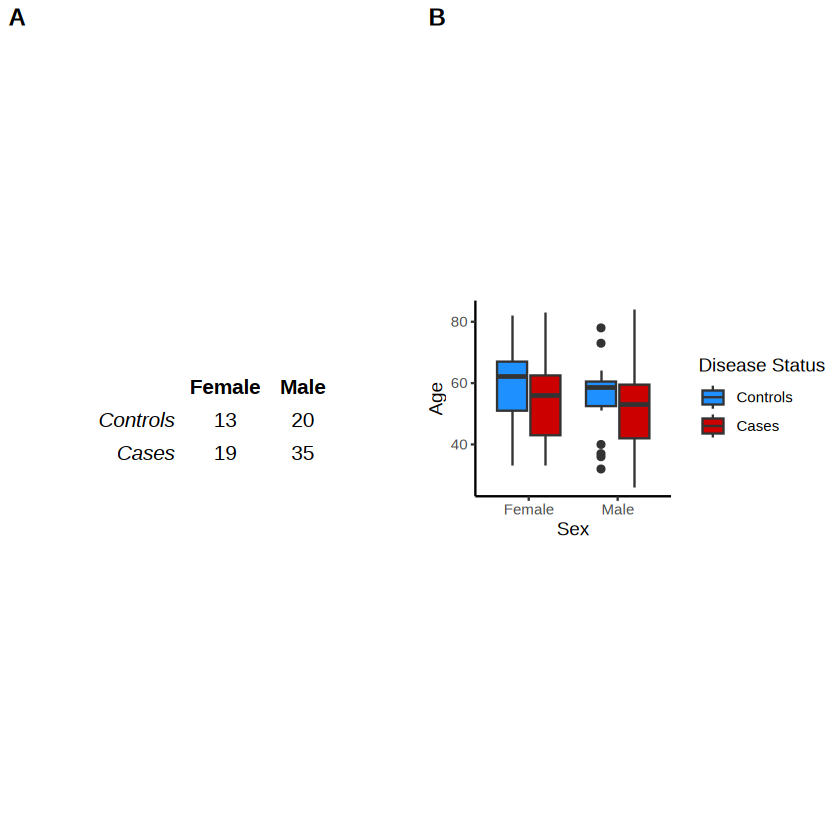

In [11]:
# Summarize demographics
df <- colData(pb) %>%
  as_tibble %>%
  select(individual, Disease_Status, Sex, Age) %>%
  distinct

#xtabs( ~ Disease_Status + Sex, df)

figB <- df %>%
  ggplot(aes(Sex, Age, fill=Disease_Status)) +
    geom_boxplot() + 
    theme_classic() +
    theme(aspect.ratio=1) +
    scale_fill_manual("Disease Status", values = c("dodgerblue", "red3"))

t1 <- tableGrob(xtabs( ~ Disease_Status + Sex, df), theme = ttheme_minimal())
fig <- plot_grid(t1, figB, ncol = 2, labels=LETTERS)
fig

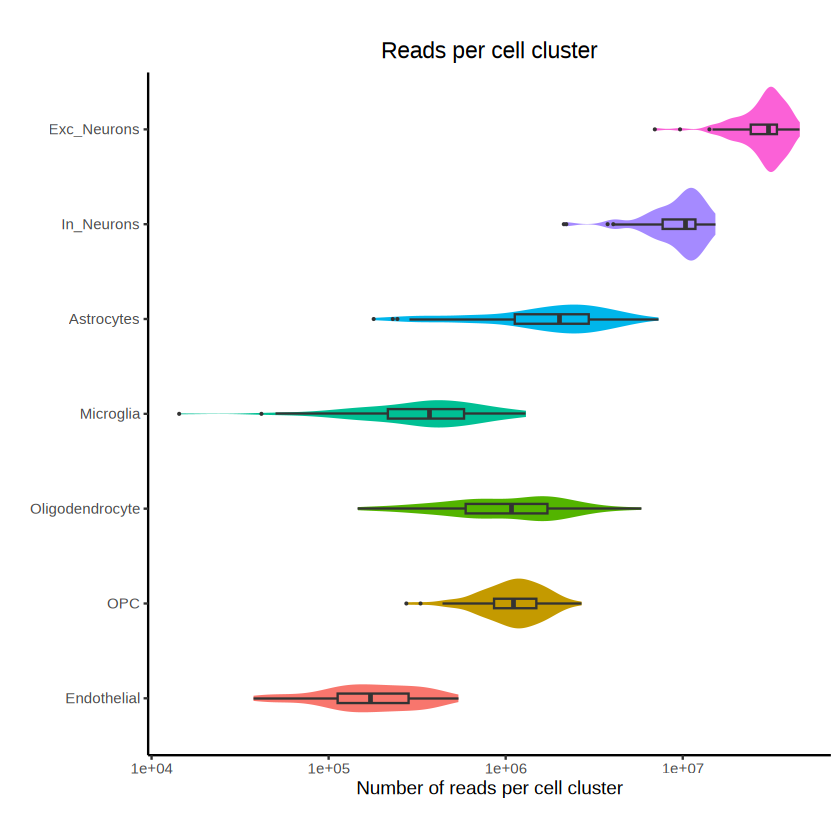

In [12]:
## Summarize read counts
df_counts <- lapply( assayNames(pb), function(x){
  data = assay(pb, x)

  data.frame(celltype = x, ID = colnames(data), readCounts = colSums(data))
})
df_counts <- do.call(rbind, df_counts)
df_counts$celltype = factor(df_counts$celltype, rev(ctorder))  

ggplot(df_counts, aes(celltype, readCounts, fill=celltype)) +  
    geom_violin(color = NA) + 
    geom_boxplot(width=.1, outlier.size=.1) +
    theme_classic() + 
    theme(aspect.ratio=1, plot.title = element_text(hjust = 0.5),
      legend.position="none") + 
    scale_y_log10() +
    coord_flip() +
    ylab("Number of reads per cell cluster") +
    xlab('') +
    ggtitle('Reads per cell cluster')

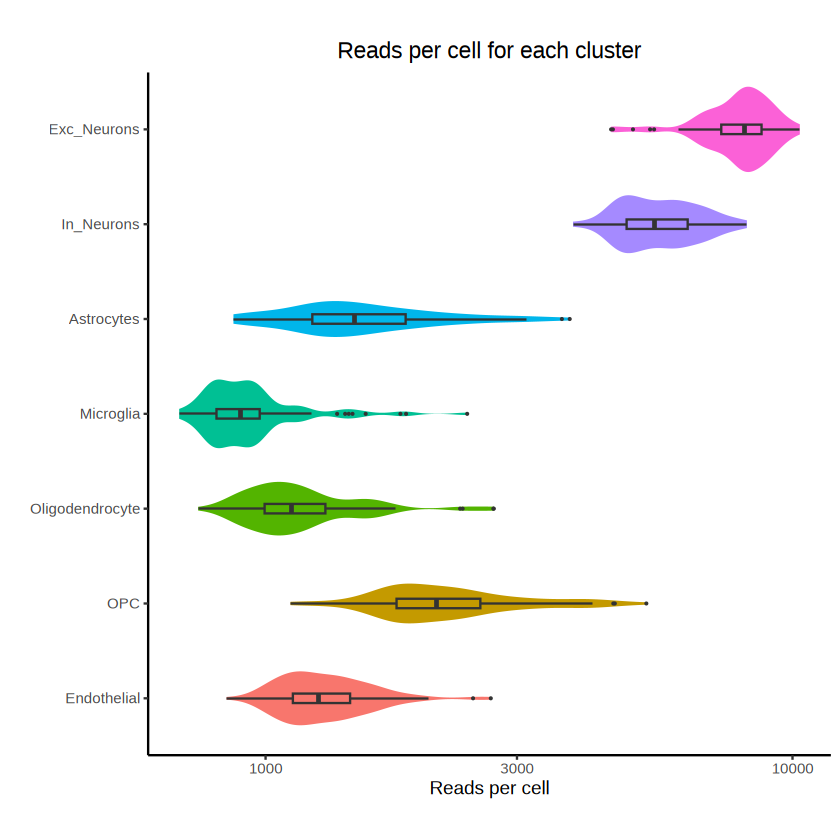

In [13]:
# extract cell counts
df_rate <- cellCounts(pb) %>%
            as.data.frame %>%
            mutate(ID = rownames(.))  %>% 
            pivot_longer(cols=-ID, values_to="ncells", names_to="celltype") %>%
            mutate(celltype = factor(celltype, rev(ctorder)))

# plot reads per cell
inner_join(df_counts, df_rate, by=c("celltype", "ID")) %>%
  ggplot(aes(celltype, readCounts/ncells, fill=celltype)) +  
    geom_violin(color = NA) + 
    geom_boxplot(width=.1, outlier.size=.1) +
    theme_classic() + 
    theme(aspect.ratio=1, plot.title = element_text(hjust = 0.5),
          legend.position="none") + 
    scale_y_log10() +
    coord_flip() +
    ylab('Reads per cell') +
    xlab('') +
    ggtitle('Reads per cell for each cluster')

# Process data: log2 CPM + voom precision weights

## Normalization

In [10]:
# turn warnings back on
options(warn=0)

In [14]:
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1

res.proc <- processAssays(pb, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

  Exc_Neurons...
4.3 mins

  In_Neurons...
4.1 mins

  Astrocytes...
3.9 mins

  Endothelial...
3.4 mins

  Microglia...
3.2 mins

  Oligodendrocyte...
3.6 mins

  OPC...
3.7 mins



In [15]:
# view details of dropping samples
details(res.proc)

assay,n_retain,formula,formDropsTerms,n_genes,n_errors,error_initial
<chr>,<int>,<chr>,<lgl>,<int>,<int>,<lgl>
Exc_Neurons,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,19942,0,FALSE
In_Neurons,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,16380,0,FALSE
Astrocytes,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,11454,0,FALSE
Endothelial,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,2721,0,FALSE
Microglia,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,5260,0,FALSE
Oligodendrocyte,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,8931,0,FALSE
OPC,87,~(1 | X6.Batch) + (1 | Sex) + (1 | Disease_Status) + Age + PMI + RIN + Brain.pH + PC1,FALSE,9520,0,FALSE


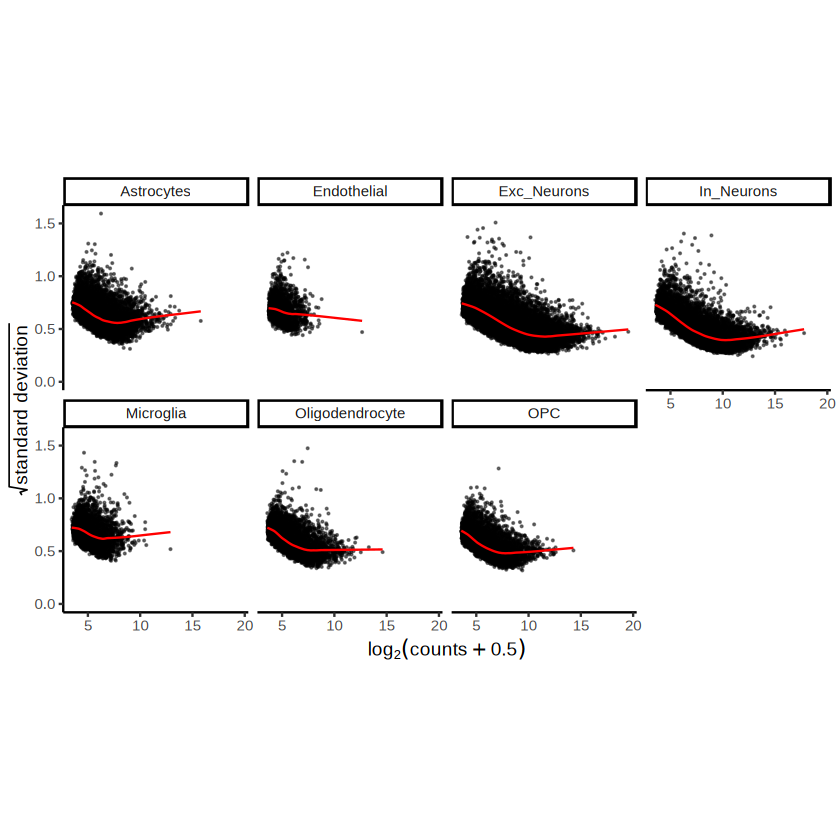

In [17]:
### Show voom-style mean-variance trends
# show voom plot for each cell clusters  
plotVoom(res.proc,assays=ctorder, ncol=4)

In [19]:
pdf(file = "../figures/dreamlet_Voom_major_celltypes_20231123.pdf", 
    width = 8, 
    height = 6)

plotVoom(res.proc,assays=ctorder, ncol=4) + theme_classic()
dev.off()

png 
  2

## Variance partitioning

In [11]:
# run variance partitioning analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.vp <- fitVarPart(res.proc, form, BPPARAM = SnowParam(12))

  Exc_Neurons...
1.6 mins

  In_Neurons...
1.4 mins

  Astrocytes...
1.1 mins

  Endothelial...
38 secs

  Microglia...
46 secs

  Oligodendrocyte...
57 secs

  OPC...
59 secs






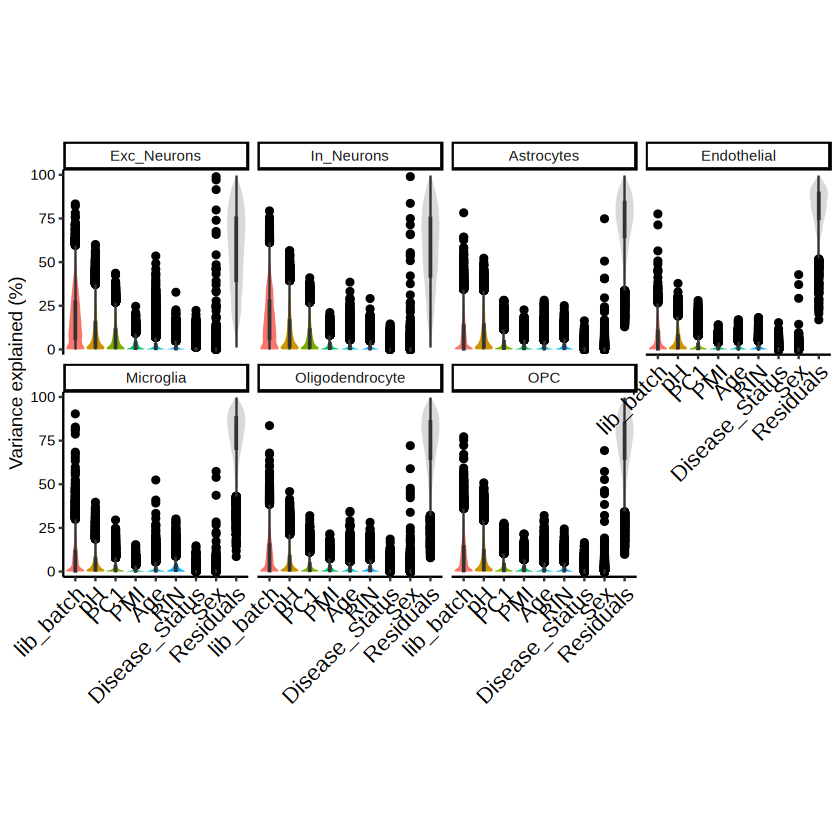

In [12]:
#colnames(res.vp)
colnames(res.vp)[colnames(res.vp) == "X6.Batch"] <- 'lib_batch'
colnames(res.vp)[colnames(res.vp) == "Brain.pH"] <- 'pH'
 
plotVarPart( sortCols(res.vp), label.angle=45, ncol=4 )

# Differential Gene Expression Analysis

## Age

In [40]:
# ~ 1h 10 min
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1

fit <- dreamlet(res.proc, form, BPPARAM = SnowParam(12))

  Exc_Neurons...
18 mins

  In_Neurons...
15 mins

  Astrocytes...
11 mins

  Endothelial...
2.8 mins

  Microglia...
5.4 mins

  Oligodendrocyte...
8.5 mins

  OPC...
9 mins


Of 74,208 models fit across all assays, 0.734% failed




In [41]:
df_de_Age <- fit %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  
df_de_Age

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astrocytes,11401,501,262,0.2292459
Endothelial,2714,84,34,0.2025991
Exc_Neurons,19733,2256,1406,0.4010635
In_Neurons,16239,1299,723,0.3861450
Microglia,5233,223,118,0.1665227
OPC,9462,425,238,0.2086778
Oligodendrocyte,8881,360,173,0.2927747


In [24]:
DE_results_Age <- fit %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age <- as.data.frame(DE_results_Age)

In [25]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_res_Age_list <- list()
for (celltype in assayNames(pb)){
    DE_res_Age_list[[celltype]] <- DE_results_Age[DE_results_Age$assay==celltype,] 
}

library(writexl)
write_xlsx(DE_res_Age_list, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_major_celltypes_20231123.xlsx", col_names = TRUE)

## Supplementary Table 7

In [2]:
library(readxl)
library(dplyr)

# read in the gene information from adata object to obtain gene name (ID) and ensembl ID
var <- read.delim("../datasets/adata.var_20231120.tsv", sep='\t')

#select gene ID and ensembl ID
gene_names_ensembl <- var %>% select('X', 'gene_ids')
gene_names_ensembl <- as.data.frame(gene_names_ensembl)
colnames(gene_names_ensembl) <- c('ID', 'ensembl')

celltypes <- c('Astrocytes', 'Endothelial','Exc_Neurons', 'In_Neurons', 
               'Microglia', "Oligodendrocyte", 'OPC')

# Age
DE_Age_results <- list()
for (celltype in celltypes){
    DE_Age_results[[celltype]] <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_major_celltypes_20231123.xlsx', sheet = celltype))
    DE_Age_results[[celltype]] <- merge(DE_Age_results[[celltype]], gene_names_ensembl , by='ID')
}


# row bind individual dataframes to one dataframe
DE_Age <- bind_rows(DE_Age_results)
DE_Age <- DE_Age %>% select(c('assay','ID', 'ensembl', 'logFC','AveExpr','t','P.Value','adj.P.Val','B','z.std' ))
head(DE_Age)

library(writexl)
#write_xlsx(DE_Age, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_w_ensembl_major_celltypes_20231123.xlsx", col_names = TRUE)

,assay,ID,ensembl,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Astrocytes,A2ML1,ENSG00000166535,0.0044704488,5.251099,0.8089098,0.4209909,0.7334472,-7.792979,0.8047032
2,Astrocytes,A2ML1-AS1,ENSG00000256661,0.0041146629,3.413098,0.6478226,0.5190472,0.7947747,-7.658173,0.6448148
3,Astrocytes,AAAS,ENSG00000094914,0.0050293665,4.543850,1.4257622,0.1579225,0.4782735,-7.002349,1.4120932
4,Astrocytes,AACS,ENSG00000081760,-0.0025150771,5.046425,-1.0398872,0.3017234,0.6385818,-7.533816,-1.0327447
5,Astrocytes,AADAT,ENSG00000109576,-0.0073241868,4.835957,-1.5721270,0.1195359,0.4222592,-6.845044,-1.5567247
6,Astrocytes,AAGAB,ENSG00000103591,-0.0009505492,5.483501,-0.3942062,0.6943894,0.8849412,-8.086304,-0.3929053


In [3]:
df_de_Age <- DE_Age %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05)) %>%
mutate(assay = factor(assay))  
df_de_Age

assay,nGenes_tested,nDE_0.1,nDE_0.05
<fct>,<int>,<int>,<int>
Astrocytes,11401,501,262
Endothelial,2714,84,34
Exc_Neurons,19733,2256,1406
In_Neurons,16239,1299,723
Microglia,5233,223,118
OPC,9462,425,238
Oligodendrocyte,8881,360,173


In [4]:
# Number of genes DE across all 7 major cell types
DE_res_Age_list <- list()
for (celltype in unique(DE_Age$assay)){
    tmp <- DE_Age[DE_Age$assay==celltype,] 
    DE_res_Age_list[[celltype]] <- tmp[tmp$adj.P.Val < 0.05,]
}

Reduce(intersect, list(DE_res_Age_list[["Astrocytes"]]$ID, DE_res_Age_list[["Endothelial"]]$ID,
                      DE_res_Age_list[["Exc_Neurons"]]$ID, DE_res_Age_list[["In_Neurons"]]$ID,
                      DE_res_Age_list[["Microglia"]]$ID,DE_res_Age_list[["Oligodendrocyte"]]$ID,
                      DE_res_Age_list[["OPC"]]$ID))

[1] "NRGN"

In [5]:
# downregulated across all cell types
DE_res_Age_list[["Astrocytes"]][DE_res_Age_list[["Astrocytes"]]$ID=='NRGN','logFC']
DE_res_Age_list[["Endothelial"]][DE_res_Age_list[["Endothelial"]]$ID=='NRGN','logFC']
DE_res_Age_list[["Exc_Neurons"]][DE_res_Age_list[["Exc_Neurons"]]$ID=='NRGN','logFC']
DE_res_Age_list[["In_Neurons"]][DE_res_Age_list[["In_Neurons"]]$ID=='NRGN', 'logFC']
DE_res_Age_list[["Microglia"]][DE_res_Age_list[["Microglia"]]$ID=='NRGN','logFC']
DE_res_Age_list[["Oligodendrocyte"]][DE_res_Age_list[["Oligodendrocyte"]]$ID=='NRGN', 'logFC']
DE_res_Age_list[["OPC"]][DE_res_Age_list[["OPC"]]$ID=='NRGN','logFC']

[1] -0.01950517

[1] -0.0197877

[1] -0.01290264

[1] -0.01278523

[1] -0.0224343

[1] -0.01901653

[1] -0.01947841

# Session Info

In [26]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] writexl_1.4.2               readxl_1.4.3               
 [3] gridExtra_2.3               HDF5Array_1.30.0           
 [5] rhdf5_2.46.0                ggrepel_0.9.4              
 [7]